In [39]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Define a simple CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training the model
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:  # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

# Evaluate the model on train and test data
def evaluate_model(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

train_accuracy = evaluate_model(net, trainloader)
test_accuracy = evaluate_model(net, testloader)

print('Accuracy on train set: %.2f %%' % train_accuracy)
print('Accuracy on test set: %.2f %%' % test_accuracy)


Finished Training
Accuracy on train set: 99.46 %
Accuracy on test set: 99.04 %


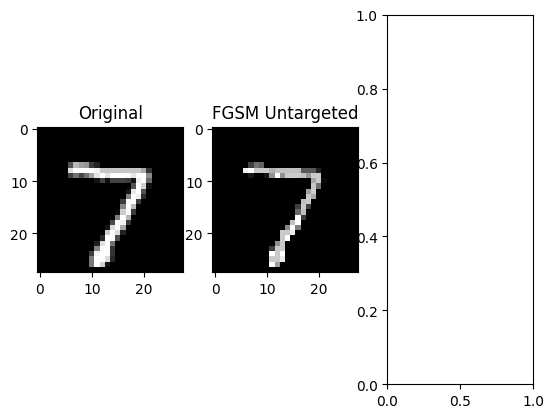

In [40]:
# Task 2:
# FGSM Untargeted

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def generate_fgsm_attack(model, criterion, image, label, epsilon):
    image.requires_grad = True
    output = model(image)
    loss = criterion(output, label)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    perturbed_image = fgsm_attack(image, epsilon, data_grad)
    return perturbed_image

# Choose an image from the dataset
image, label = testset[0][0].unsqueeze(0), torch.tensor([testset[0][1]])

# FGSM Untargeted Attack
epsilon = 0.2  # Example epsilon value
perturbed_image_fgsm = generate_fgsm_attack(net, criterion, image, label, epsilon)

# Visualize and compare images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image.squeeze().detach().numpy(), cmap='gray')
axs[0].set_title('Original')

axs[1].imshow(perturbed_image_fgsm.squeeze().detach().numpy(), cmap='gray')
axs[1].set_title('FGSM Untargeted')

plt.show()


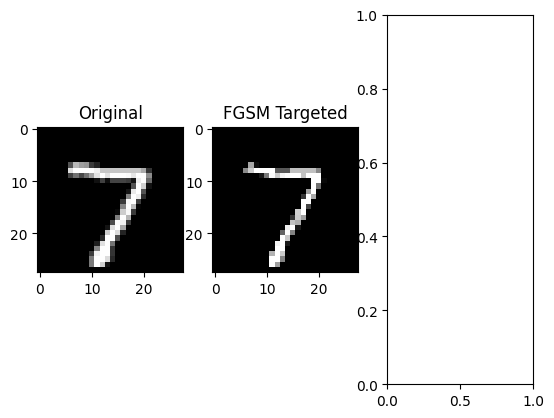

In [41]:
# FGSM Targeted Attack
def generate_targeted_fgsm_attack(model, criterion, image, target_label, epsilon):
    image.requires_grad = True
    output = model(image)
    loss = criterion(output, target_label)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    perturbed_image = fgsm_attack(image, epsilon, data_grad)
    return perturbed_image

# Choose an image from the dataset
image, label = testset[0][0].unsqueeze(0), torch.tensor([testset[0][1]])

# FGSM Targeted Attack
target_label = torch.tensor([3])  # Example target label
perturbed_image_fgsm_targeted = generate_targeted_fgsm_attack(net, criterion, image, target_label, epsilon)

# Visualize and compare images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image.squeeze().detach().numpy(), cmap='gray')
axs[0].set_title('Original')

axs[1].imshow(perturbed_image_fgsm_targeted.squeeze().detach().numpy(), cmap='gray')
axs[1].set_title('FGSM Targeted')

plt.show()


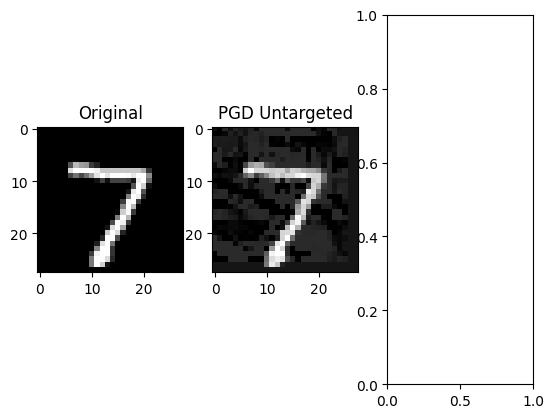

In [42]:
# PGD untargeted attack
def pgd_attack(model, criterion, image, label, epsilon, alpha, num_steps):
    perturbed_image = image.clone().detach()
    for _ in range(num_steps):
        perturbed_image.requires_grad = True
        output = model(perturbed_image)
        loss = criterion(output, label)
        model.zero_grad()
        loss.backward()
        data_grad = perturbed_image.grad.data
        perturbed_image = perturbed_image + alpha * torch.sign(data_grad)
        perturbed_image = torch.max(torch.min(perturbed_image, image + epsilon), image - epsilon).detach()
    return perturbed_image

# Choose an image from the dataset
image, label = testset[0][0].unsqueeze(0), torch.tensor([testset[0][1]])

# PGD Untargeted Attack
alpha = 0.01  # Example alpha value
num_steps = 40  # Example number of steps
perturbed_image_pgd = pgd_attack(net, criterion, image, label, epsilon, alpha, num_steps)

# Visualize and compare images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image.squeeze().detach().numpy(), cmap='gray')
axs[0].set_title('Original')

axs[1].imshow(perturbed_image_pgd.squeeze().detach().numpy(), cmap='gray')
axs[1].set_title('PGD Untargeted')

plt.show()


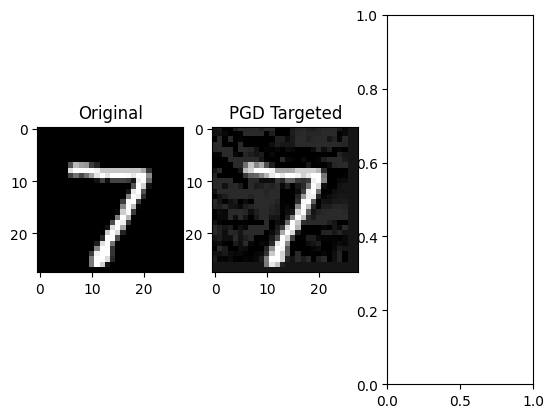

In [43]:
#PGD targeted
def pgd_targeted_attack(model, criterion, image, target_label, epsilon, alpha, num_steps):
    perturbed_image = image.clone().detach()
    for _ in range(num_steps):
        perturbed_image.requires_grad = True
        output = model(perturbed_image)
        loss = criterion(output, target_label)
        model.zero_grad()
        loss.backward()
        data_grad = perturbed_image.grad.data
        perturbed_image = perturbed_image + alpha * torch.sign(data_grad)
        perturbed_image = torch.max(torch.min(perturbed_image, image + epsilon), image - epsilon).detach()
    return perturbed_image

# Choose an image from the dataset
image, label = testset[0][0].unsqueeze(0), torch.tensor([testset[0][1]])

# PGD Targeted Attack
target_label = torch.tensor([3])  # Example target label
perturbed_image_pgd_targeted = pgd_targeted_attack(net, criterion, image, target_label, epsilon, alpha, num_steps)

# Visualize and compare images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image.squeeze().detach().numpy(), cmap='gray')
axs[0].set_title('Original')

axs[1].imshow(perturbed_image_pgd_targeted.squeeze().detach().numpy(), cmap='gray')
axs[1].set_title('PGD Targeted')

plt.show()


In [50]:
# Task 3
def test_attack(model, criterion, attack_fn, testloader, epsilon_values, alpha=None, num_steps=None, target_label=None):
    attack_type = attack_fn.__name__.split('_')[0].upper()  # Get the attack type (FGSM or PGD)
    results = {}
    
    for epsilon in epsilon_values:
        accuracy_list = []
        for images, labels in testloader:
            images.requires_grad = True
            outputs = model(images)
            batch_size = images.size(0)
            
            if attack_fn == fgsm_attack:
                perturbed_images = generate_fgsm_attack(model, criterion, images, labels, epsilon)
            elif attack_fn == pgd_attack:
                perturbed_images = pgd_attack(model, criterion, images, labels, epsilon, alpha, num_steps)
            elif attack_fn == generate_targeted_fgsm_attack:
                perturbed_images = generate_targeted_fgsm_attack(model, criterion, images, labels, epsilon)
            
            perturbed_outputs = model(perturbed_images)
            _, predicted = torch.max(perturbed_outputs, 1)
            accuracy = (predicted == labels).sum().item() / batch_size
            accuracy_list.append(accuracy)
        
        results[epsilon] = sum(accuracy_list) / len(accuracy_list)
        print(f'{attack_type} Accuracy (Epsilon={epsilon}): {results[epsilon]}')

    return results

# Define epsilon values to test
epsilon_values = [0.05, 0.15, 0.25]  # Example epsilon values

# Test FGSM and PGD attacks on the test set with different epsilon values
print("\nFGSM Untargeted:")
fgsm_untargeted_results = test_attack(net, criterion, fgsm_attack, testloader, epsilon_values)

print("\nFGSM Targeted:")
fgsm_targeted_results = test_attack(net, criterion, generate_targeted_fgsm_attack, testloader, epsilon_values)

print("\nPGD Untargeted:")
pgd_untargeted_results = test_attack(net, criterion, pgd_attack, testloader, epsilon_values, alpha=0.01, num_steps=40)

print("\nPGD Targeted:")
pgd_targeted_results = test_attack(net, criterion, pgd_targeted_attack, testloader, epsilon_values, alpha=0.01, num_steps=40, target_label=torch.tensor([3]))



FGSM Untargeted:
FGSM Accuracy (Epsilon=0.05): 0.9366042993630573
FGSM Accuracy (Epsilon=0.15): 0.8784832802547771
FGSM Accuracy (Epsilon=0.25): 0.7833399681528662

FGSM Targeted:
GENERATE Accuracy (Epsilon=0.05): 0.9366042993630573
GENERATE Accuracy (Epsilon=0.15): 0.8784832802547771
GENERATE Accuracy (Epsilon=0.25): 0.7833399681528662

PGD Untargeted:
PGD Accuracy (Epsilon=0.05): 0.9591958598726115
PGD Accuracy (Epsilon=0.15): 0.6272890127388535
PGD Accuracy (Epsilon=0.25): 0.12878184713375795

PGD Targeted:


UnboundLocalError: cannot access local variable 'perturbed_images' where it is not associated with a value

FGSM Accuracy (Epsilon=0.05): 0.9366042993630573
FGSM Accuracy (Epsilon=0.1): 0.9121218152866242
FGSM Accuracy (Epsilon=0.15): 0.8784832802547771
FGSM Accuracy (Epsilon=0.2): 0.8358877388535032
FGSM Accuracy (Epsilon=0.25): 0.7833399681528662
FGSM Accuracy (Epsilon=0.3): 0.7240246815286624
PGD Accuracy (Epsilon=0.05): 0.9591958598726115
PGD Accuracy (Epsilon=0.1): 0.8623606687898089
PGD Accuracy (Epsilon=0.15): 0.6272890127388535
PGD Accuracy (Epsilon=0.2): 0.32414410828025475
PGD Accuracy (Epsilon=0.25): 0.12878184713375795
PGD Accuracy (Epsilon=0.3): 0.05224920382165605


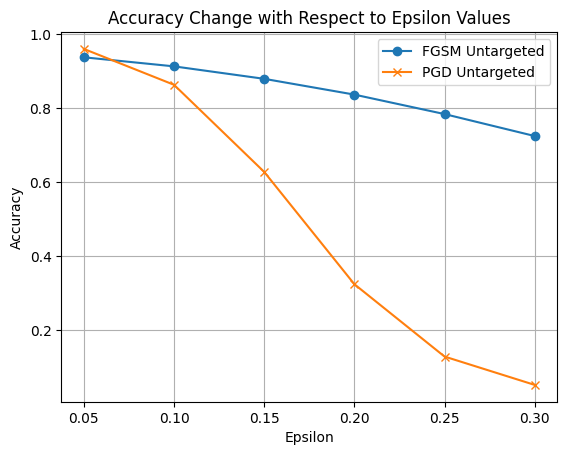

In [46]:
# Task 4
import matplotlib.pyplot as plt

epsilon_values = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]  # Epsilon values to test

# Test FGSM and PGD attacks on the test set with different epsilon values
fgsm_untargeted_results = test_attack(net, criterion, fgsm_attack, testloader, epsilon_values)
pgd_untargeted_results = test_attack(net, criterion, pgd_attack, testloader, epsilon_values, alpha=0.01, num_steps=40)

# Plotting accuracy change with respect to epsilon values
plt.plot(epsilon_values, list(fgsm_untargeted_results.values()), label='FGSM Untargeted', marker='o')
plt.plot(epsilon_values, list(pgd_untargeted_results.values()), label='PGD Untargeted', marker='x')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy Change with Respect to Epsilon Values')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
# # b) Determining the Best Attack and Listing Pros and Cons
# # To determine the best attack and list pros and cons, we need to analyze the results obtained from each attack and consider various factors such as effectiveness, robustness, computational complexity, and specific use cases. 

# Fast Gradient Sign Method (FGSM)
# Pros:
# Simplicity: FGSM is straightforward to implement and understand.
# Fast: It requires only a single forward and backward pass through the network, making it computationally efficient.
# Effective: FGSM can achieve significant perturbation of input images, leading to misclassification.
# Cons:
# Brittleness: FGSM perturbations are often easily detectable and can be fragile to small changes, limiting its robustness.
# Untargeted Only: FGSM generates perturbations to maximize the loss without considering a specific target class, making it suitable only for untargeted attacks.
# Limited ε Sensitivity: FGSM might not perform well with large ε values, as it may result in overly perturbed images with reduced visual similarity to the original.
# Projected Gradient Descent (PGD)
# Pros:
# Robustness: PGD iteratively applies FGSM steps with smaller step sizes, making it more robust against defense mechanisms like gradient masking or gradient obfuscation.
# Flexibility: PGD allows for both untargeted and targeted attacks, offering more versatility in attack strategies.
# Customizable: Parameters like step size, number of steps, and ε can be adjusted to tailor the attack to specific scenarios.
# Cons:
# Computational Complexity: PGD requires multiple iterations of FGSM, leading to increased computational overhead compared to FGSM.
# Gradient Estimation: PGD relies on gradient estimation, which may not always accurately represent the true gradient direction, potentially affecting the effectiveness of the attack.
# Sensitivity to Parameters: The performance of PGD can be sensitive to parameter choices, requiring careful tuning for optimal results.
# Determining the Best Attack
# The choice of the best attack depends on various factors, including the specific task requirements, the robustness of the target model, and the available computational resources.

# For Robustness: PGD is generally preferred due to its iterative nature, which improves robustness against defense mechanisms.
# For Speed: FGSM may be chosen when computational efficiency is a priority, as it requires fewer iterations.
# For Versatility: PGD offers more flexibility with both untargeted and targeted attacks, making it suitable for a wider range of scenarios.
# When to Use Targeted vs. Untargeted Attacks
# Untargeted Attacks: These are used when the goal is to simply cause misclassification, without specifying a particular target class. FGSM and PGD untargeted variants fall into this category.
# Targeted Attacks: These are employed when the attacker aims to manipulate the model's prediction to a specific chosen class. Targeted attacks can be more challenging for the defender to detect and mitigate effectively. FGSM and PGD targeted variants support this strategy.
# In summary, the choice between FGSM and PGD depends on the specific requirements of the attack scenario, including the desired trade-off between computational efficiency, robustness, and attack versatility. Would you like to delve deeper into any specific aspect of this analysis?






